In [2]:
import pandas as pd
import numpy as np
from pathlib import Path

DATA_PATH = Path("CarSales.csv")   # edit if needed
df_raw = pd.read_csv(DATA_PATH)
print(df_raw.shape)
df_raw.head()


(23906, 16)


,Car_id,Date,Customer Name,Gender,Annual Income,Dealer_Name,Company,Model,Engine,Transmission,Color,Price,Dealer_No,Body Style,Phone,Dealer_Region
0,C_CND_000001,1/2/2022,Geraldine,Male,13500,Buddy Storbeck's Diesel Service Inc,Ford,Expedition,DoubleÂ Overhead Camshaft,Auto,Black,26000,06457-3834,SUV,8264678,Middletown
1,C_CND_000002,1/2/2022,Gia,Male,1480000,C & M Motors Inc,Dodge,Durango,DoubleÂ Overhead Camshaft,Auto,Black,19000,60504-7114,SUV,6848189,Aurora
2,C_CND_000003,1/2/2022,Gianna,Male,1035000,Capitol KIA,Cadillac,Eldorado,Overhead Camshaft,Manual,Red,31500,38701-8047,Passenger,7298798,Greenville
3,C_CND_000004,1/2/2022,Giselle,Male,13500,Chrysler of Tri-Cities,Toyota,Celica,Overhead Camshaft,Manual,Pale White,14000,99301-3882,SUV,6257557,Pasco
4,C_CND_000005,1/2/2022,Grace,Male,1465000,Chrysler Plymouth,Acura,TL,DoubleÂ Overhead Camshaft,Auto,Red,24500,53546-9427,Hatchback,7081483,Janesville


In [3]:
df = df_raw.copy()
df.columns = (df.columns.str.strip()       # remove leading/trailing blanks
                     .str.lower()
                     .str.replace('[^0-9a-z]+', '_', regex=True))
df.columns


Index(['car_id', 'date', 'customer_name', 'gender', 'annual_income',
       'dealer_name', 'company', 'model', 'engine', 'transmission', 'color',
       'price', 'dealer_no', 'body_style', 'phone', 'dealer_region'],
      dtype='object')

In [5]:
drop_cols = ['car_id', 'phone','customer_name']            # keep dealer_no (ZIP-ish) for now
df = df.drop(columns=drop_cols)


In [7]:
df['engine'] = df['engine'].str.encode('latin1', errors='ignore').str.decode('utf-8', errors='ignore')
# price: strip $, commas; income: already numeric but force int
df['price'] = (df['price']
                 .astype(str)
                 .str.replace('[\\$,]', '', regex=True)
                 .astype(float))

df['annual_income'] = df['annual_income'].astype(int)

df['sale_date'] = pd.to_datetime(df['date'])
df = df.drop(columns=['date'])

df['sale_month']   = df['sale_date'].dt.to_period('M')
df['sale_quarter'] = df['sale_date'].dt.to_period('Q')
df['year']         = df['sale_date'].dt.year
df.head()


,gender,annual_income,dealer_name,company,model,engine,transmission,color,price,dealer_no,body_style,dealer_region,sale_date,sale_month,sale_quarter,year
0,Male,13500,Buddy Storbeck's Diesel Service Inc,Ford,Expedition,DoubleOverhead Camshaft,Auto,Black,26000.0,06457-3834,SUV,Middletown,2022-01-02,2022-01,2022Q1,2022
1,Male,1480000,C & M Motors Inc,Dodge,Durango,DoubleOverhead Camshaft,Auto,Black,19000.0,60504-7114,SUV,Aurora,2022-01-02,2022-01,2022Q1,2022
2,Male,1035000,Capitol KIA,Cadillac,Eldorado,Overhead Camshaft,Manual,Red,31500.0,38701-8047,Passenger,Greenville,2022-01-02,2022-01,2022Q1,2022
3,Male,13500,Chrysler of Tri-Cities,Toyota,Celica,Overhead Camshaft,Manual,Pale White,14000.0,99301-3882,SUV,Pasco,2022-01-02,2022-01,2022Q1,2022
4,Male,1465000,Chrysler Plymouth,Acura,TL,DoubleOverhead Camshaft,Auto,Red,24500.0,53546-9427,Hatchback,Janesville,2022-01-02,2022-01,2022Q1,2022


In [8]:
df = df.drop_duplicates()

# inspect NA %
na_rate = df.isna().mean().sort_values(ascending=False)
print(na_rate.head(10))


gender           0.0
annual_income    0.0
dealer_name      0.0
company          0.0
model            0.0
engine           0.0
transmission     0.0
color            0.0
price            0.0
dealer_no        0.0
dtype: float64


In [12]:
df.to_csv("clean_car_data.csv", index=False)
print("Saved as clean_car_data.csv")



Saved as clean_car_data.csv


In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

cat_cols = df.select_dtypes('object').columns.tolist()
num_cols = ['price', 'annual_income']          # target(s) excluded

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num', StandardScaler(), num_cols)
])


In [ ]:

import pandas as pd, textwrap

n_rows, n_cols = df.shape

price_min = df['price'].min()
price_max = df['price'].max()
price_med = df['price'].median()

inc_min   = df['annual_income'].min()
inc_max   = df['annual_income'].max()
inc_med   = df['annual_income'].median()

top_company      = df['company'].value_counts().idxmax()
top_model        = df['model'].value_counts().idxmax()
top_engine       = df['engine'].value_counts().idxmax()
top_transmission = df['transmission'].value_counts().idxmax()
top_color        = df['color'].value_counts().idxmax()
top_body         = df['body_style'].value_counts().idxmax()

summary = textwrap.dedent(f"""
    The dataset contains **{n_rows:,} car-sales records** described by **{n_cols} features** covering
    customer demographics, vehicle specifications, dealer information and transaction price.

    • **Price** spans **${price_min:,.0f} – ${price_max:,.0f}** (median **${price_med:,.0f}**).  
    • **Annual income** spans **${inc_min:,.0f} – ${inc_max:,.0f}** (median **${inc_med:,.0f}**).

    The most frequent categories are:
       – Company **{top_company}**  
       – Model **{top_model}**  
       – Engine **{top_engine}**  
       – Transmission **{top_transmission}**  
       – Color **{top_color}**  
       – Body style **{top_body}**
""")

print(summary)
# ---------------------------------------------------------------------------



The dataset contains **23,906 car-sales records** described by **16 features** covering
customer demographics, vehicle specifications, dealer information and transaction price.

• **Price** spans **$1,200 – $85,800** (median **$23,000**).  
• **Annual income** spans **$10,080 – $11,200,000** (median **$735,000**).

The most frequent categories are:
   – Company **Chevrolet**  
   – Model **Diamante**  
   – Engine **DoubleOverhead Camshaft**  
   – Transmission **Auto**  
   – Color **Pale White**  
   – Body style **SUV**



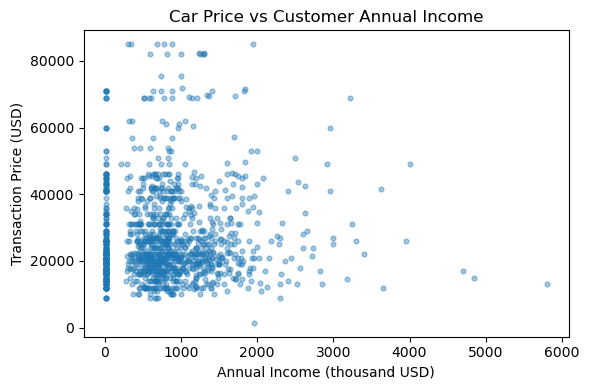

Pearson r : 0.012
Spearman ρ: 0.017


In [20]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, os
sample = df.sample(n=1200, random_state=42)

plt.figure(figsize=(6,4))

# Plot income in *thousands* of dollars
plt.scatter(sample['annual_income'] / 1_000,
            sample['price'],
            alpha=0.4, s=12)

plt.xlabel("Annual Income (thousand USD)")
plt.ylabel("Transaction Price (USD)")
plt.title("Car Price vs Customer Annual Income")
plt.tight_layout()
plt.show()



print("Pearson r :", df['price'].corr(df['annual_income'], method='pearson').round(3))
print("Spearman ρ:", df['price'].corr(df['annual_income'], method='spearman').round(3))


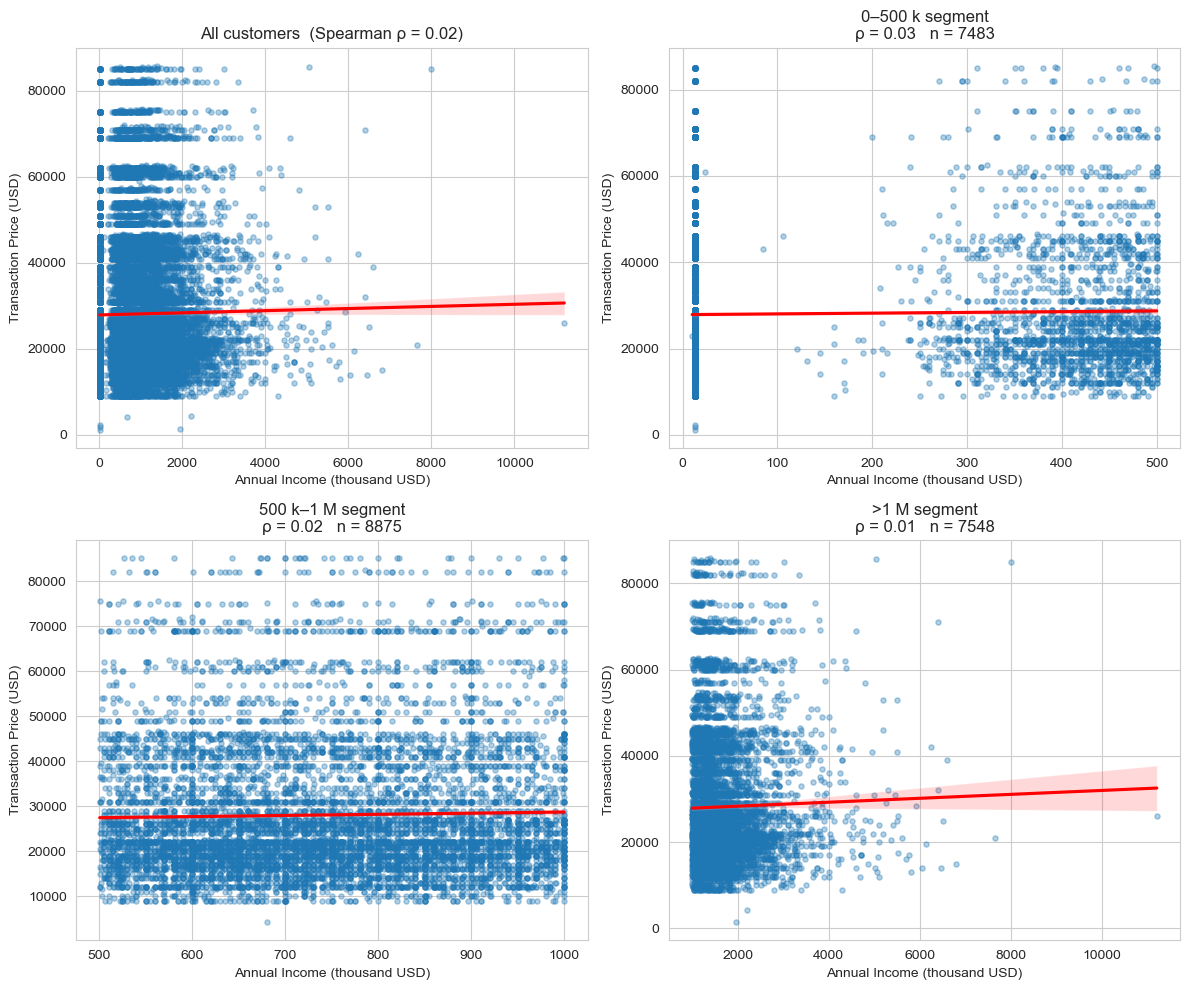

Spearman correlation – Price vs Annual Income
Segment         ρ       p-value      n
All data       0.017   0.00972   23906
0–500 k         0.028   0.0149   7483
500 k–1 M       0.016   0.126   8875
>1 M            0.006   0.629   7548


In [ ]:

import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from scipy.stats import spearmanr

# 1) Load cleaned file
DATA_PATH = "clean_car_data.csv"  
df = pd.read_csv(DATA_PATH)

# 2) Ensure numeric price & income
df['price'] = (df['price']
                 .astype(str)
                 .str.replace('[\\$,]', '', regex=True)
                 .astype(float))
df['annual_income'] = df['annual_income'].astype(float)
df = df.dropna(subset=['price', 'annual_income'])

# 3) Define income bins
bins   = [0, 500_000, 1_000_000, np.inf]
labels = ["0–500 k", "500 k–1 M", ">1 M"]
df['income_bin'] = pd.cut(df['annual_income'], bins=bins, labels=labels)

# 4) Compute Spearman for full sample
rho_full, p_full = spearmanr(df['annual_income'], df['price'])

# 5) Prepare the 2×2 figure grid
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

# Helper function for one panel
def add_panel(ax, data, title):
    sns.regplot(x=data['annual_income'] / 1_000,
                y=data['price'],
                scatter_kws=dict(alpha=0.35, s=14),
                line_kws=dict(color='red'),
                ax=ax)
    ax.set_xlabel("Annual Income (thousand USD)")
    ax.set_ylabel("Transaction Price (USD)")
    ax.set_title(title)

# Panel 
add_panel(axes[0],
          df,
          f"All customers  (Spearman ρ = {rho_full:.2f})")

corr_table = []
for ax, label in zip(axes[1:], labels):
    sub = df[df['income_bin'] == label]
    rho, p = spearmanr(sub['annual_income'], sub['price'])
    corr_table.append((label, rho, p, len(sub)))
    add_panel(ax,
              sub,
              f"{label} segment\nρ = {rho:.2f}   n = {len(sub)}")

# Clean up empty 4th panel 
if len(labels) < len(axes) - 1:
    fig.delaxes(axes[-1])

plt.tight_layout()
fig.savefig("price_vs_income_segments.png",     
            dpi=300,                            
            bbox_inches="tight",                 
            transparent=False)                  
plt.show()


print("Spearman correlation – Price vs Annual Income")
print("Segment         ρ       p-value      n")
print(f"All data       {rho_full:5.3f}   {p_full:.3g}   {len(df)}")
for seg, rho, p, n in corr_table:
    print(f"{seg:<15} {rho:5.3f}   {p:.3g}   {n}")


In [ ]:
import pandas as pd
df = pd.read_csv("clean_car_data.csv")          
print(df.columns)                               




Index(['gender', 'annual_income', 'dealer_name', 'company', 'model', 'engine',
       'transmission', 'color', 'price', 'dealer_no', 'body_style',
       'dealer_region', 'sale_date', 'sale_month', 'sale_quarter', 'year'],
      dtype='object')


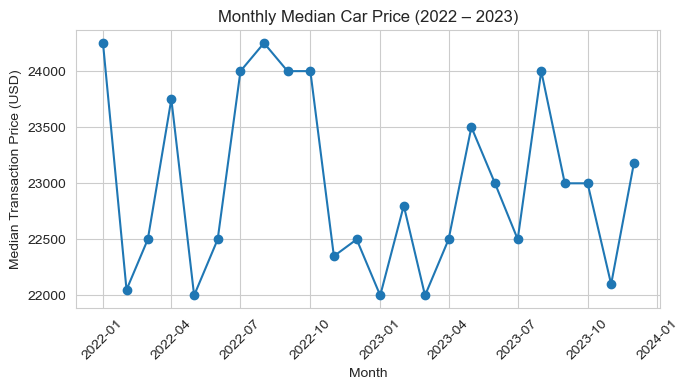

In [ ]:
import pandas as pd, matplotlib.pyplot as plt


df = pd.read_csv("clean_car_data.csv")          
df['sale_date'] = pd.to_datetime(df['sale_date'])

if df['price'].dtype == object:
    df['price'] = (df['price']
                     .str.replace('[\\$,]', '', regex=True)
                     .astype(float))


monthly = (df.assign(month=df['sale_date'].dt.to_period('M'))
             .groupby('month')['price']
             .median()
             .reset_index())
monthly['month'] = monthly['month'].dt.to_timestamp()

plt.figure(figsize=(7,4))
plt.plot(monthly['month'], monthly['price'], marker='o')
plt.xlabel("Month")
plt.ylabel("Median Transaction Price (USD)")
plt.title("Monthly Median Car Price (2022 – 2023)")
plt.xticks(rotation=45)
plt.tight_layout()


plt.savefig("price_trend_monthly.png", dpi=300, bbox_inches="tight")
plt.show()


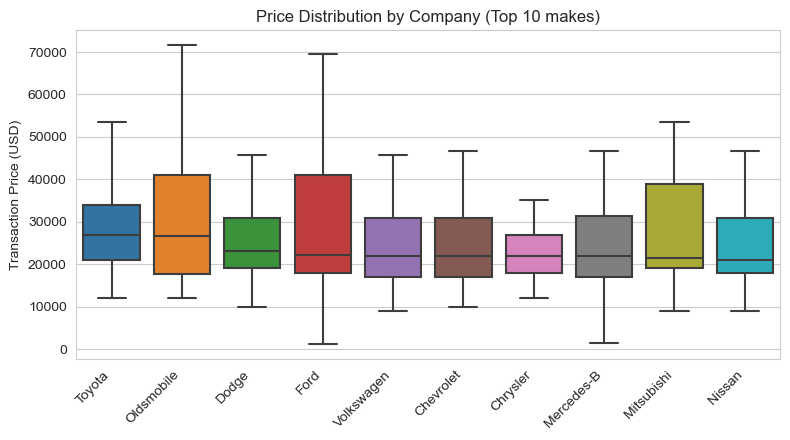

In [ ]:
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns


df = pd.read_csv("clean_car_data.csv")          # ← adjust path
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df = df.dropna(subset=['price', 'company'])

# Pick the 10 most-common companies
top10 = (df['company']
           .value_counts()
           .head(10)
           .index)
sub = df[df['company'].isin(top10)].copy()

# Order companies by median price (nice-to-have) 
order = (sub.groupby('company')['price']
            .median()
            .sort_values(ascending=False)
            .index)

# ox-plot 
plt.figure(figsize=(8, 4.5))
sns.boxplot(x='company', y='price', data=sub, order=order, showfliers=False)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Transaction Price (USD)")
plt.xlabel("")
plt.title("Price Distribution by Company (Top 10 makes)")
plt.tight_layout()
plt.savefig("price_box_by_company.png", dpi=300, bbox_inches="tight")
plt.show()

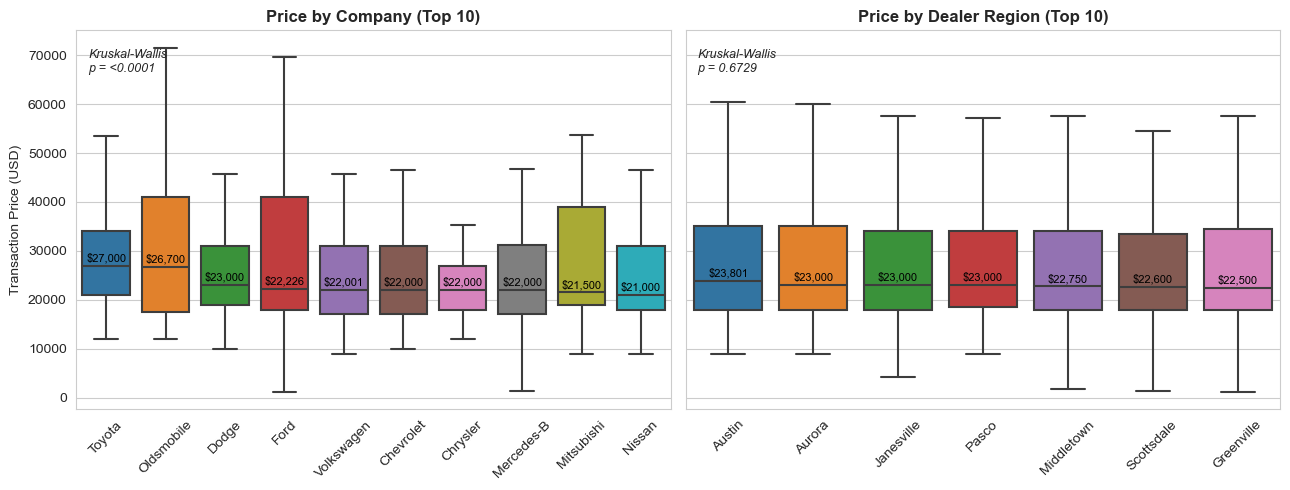

In [ ]:
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from scipy.stats import kruskal



# ensure numeric
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df = df.dropna(subset=['price', 'company', 'dealer_region'])

# Helper: keep busiest 10 groups & order by median price 
def top10(data, col):
    names = data[col].value_counts().head(10).index
    sub   = data[data[col].isin(names)].copy()
    order = (sub.groupby(col)['price']
               .median()
               .sort_values(ascending=False)
               .index)
    return sub, order

sub_cmp, ord_cmp = top10(df, 'company')
sub_reg, ord_reg = top10(df, 'dealer_region')

# Plot function (box, medians, Kruskal p) 
def add_box(ax, data, xcol, order, title):
    sns.boxplot(x=xcol, y='price', data=data, order=order,
                showfliers=False, ax=ax)
    ax.set_xlabel("")
    ax.set_title(title, fontweight="bold")
    ax.tick_params(axis='x', rotation=45)

    # annotate medians
    med = data.groupby(xcol)['price'].median().loc[order]
    for i, m in enumerate(med):
        ax.text(i, m + 500, f"${m:,.0f}", ha='center', va='bottom',
                fontsize=8, color="black")

    # Kruskal-Wallis across the 10 groups
    groups = [data.loc[data[xcol] == g, 'price'] for g in order]
    stat, p = kruskal(*groups)
    p_fmt = "<0.0001" if p < 0.0001 else f"{p:.4f}"

    ax.text(0.02, 0.95,
            f"Kruskal-Wallis\np = {p_fmt}",
            transform=ax.transAxes,
            ha='left', va='top',
            fontsize=9, fontstyle='italic')


# Build paired figure 
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(13, 5), sharey=True)

add_box(axes[0], sub_cmp, 'company', ord_cmp,
        "Price by Company (Top 10)")
axes[0].set_ylabel("Transaction Price (USD)")

add_box(axes[1], sub_reg, 'dealer_region', ord_reg,
        "Price by Dealer Region (Top 10)")
axes[1].set_ylabel("")

plt.tight_layout()
fig.savefig("price_box_company_region_stats.png", dpi=300, bbox_inches="tight")
plt.show()
